In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
#sys.path.append('/Users/kondrate/nfs/Documents/TUT/MSThesis/Scripts/tests/classes')
sys.path.append('/media/synology/Documents/TUT/MSThesis/Scripts/tests/classes')
from cp_utils import draw_plots
import time
%matplotlib inline

In [6]:
#folder = '/Users/kondrate/nfs/Documents/TUT/MSThesis/Scripts/Data/Baseline/'
folder = '/media/synology/Documents/TUT/MSThesis/Scripts/Data/NoBaseline/'
#file = 'GrapeFlaskBaseline1.mat.csv'
file = 'JasmineFlaskNoBaseline1.mat.csv'
data = pd.read_csv(folder + file).to_numpy().T
ts = np.array([data[:,i+1] - data[:,i] for i in range(data.shape[1]-1)]).T
ts.shape

(14, 300)

Test using normally distributed MMCUSUM terms

0.02319812774658203


(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000.]),
 <a list of 9 Text major ticklabel objects>)

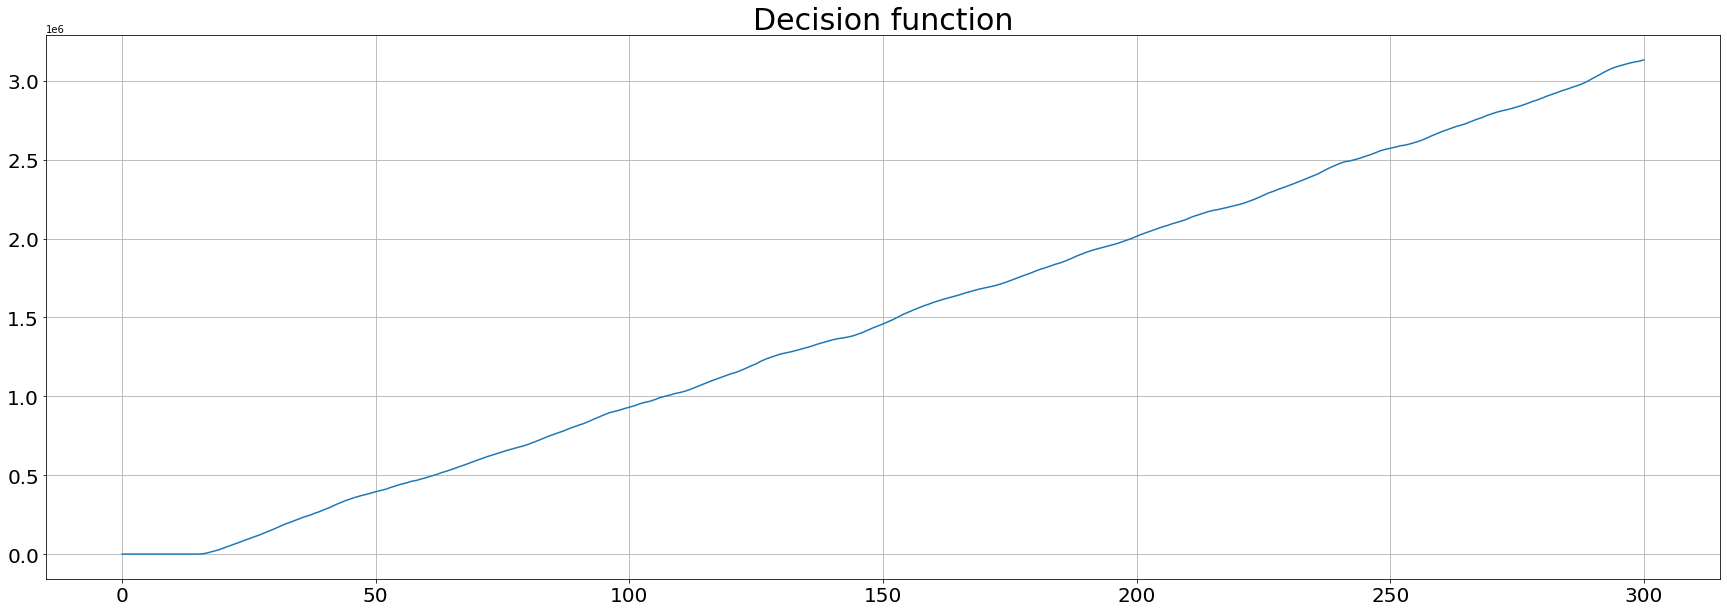

In [31]:
init_sample = ts[:,:5].reshape(14,5)
mu = np.mean(init_sample, axis=1).reshape(14,1)
cov = np.cov(init_sample).reshape(14,14)
# Add small value for avoiding singularity
np.fill_diagonal(cov, cov.diagonal() + 1e-10)
#

# a
up = np.dot((-1*mu).T, np.linalg.inv(cov))
down = np.sqrt(np.dot(np.dot((-1*mu).T, np.linalg.inv(cov)), -1*mu))
a = up/down # (shape 1,14)

# k
up = np.dot(np.dot((-1*mu).T, np.linalg.inv(cov)), -1*mu)
down = np.sqrt(np.dot(np.dot((-1*mu).T, np.linalg.inv(cov)), -1*mu))
k = 0.5*(up/down)

Si = 0
decision = [Si]
detected = False
tm = time.time()
for i in range(ts.shape[1]):
    #sample = ts[:,i].reshape(14,1) # sample one-by-one
    sample = np.mean(ts[:,i:i+5], axis=1).reshape(14,1) # taking mean of samples
    # D
    D = np.sqrt(np.dot(np.dot((-1*mu).T, np.linalg.inv(cov)), -1*mu))

    # Z
    Z = np.dot(a, sample - mu)
    #Si = np.max([decision[-1] + Z - 0.5*D, 0])
    Si = np.max([Si + Z - 0.5*D, 0])
    #print(Si, Z, D)
    if Si > 0 and detected == False:
        point = i + 5
        detected = True
    decision.append(Si)
print(time.time() - tm)
decision = np.array(decision)
plt.rcParams['figure.figsize'] = [30, 10]
plt.grid(True)
plt.title('Decision function', fontsize=30)
plt.plot(decision)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(301, 14)


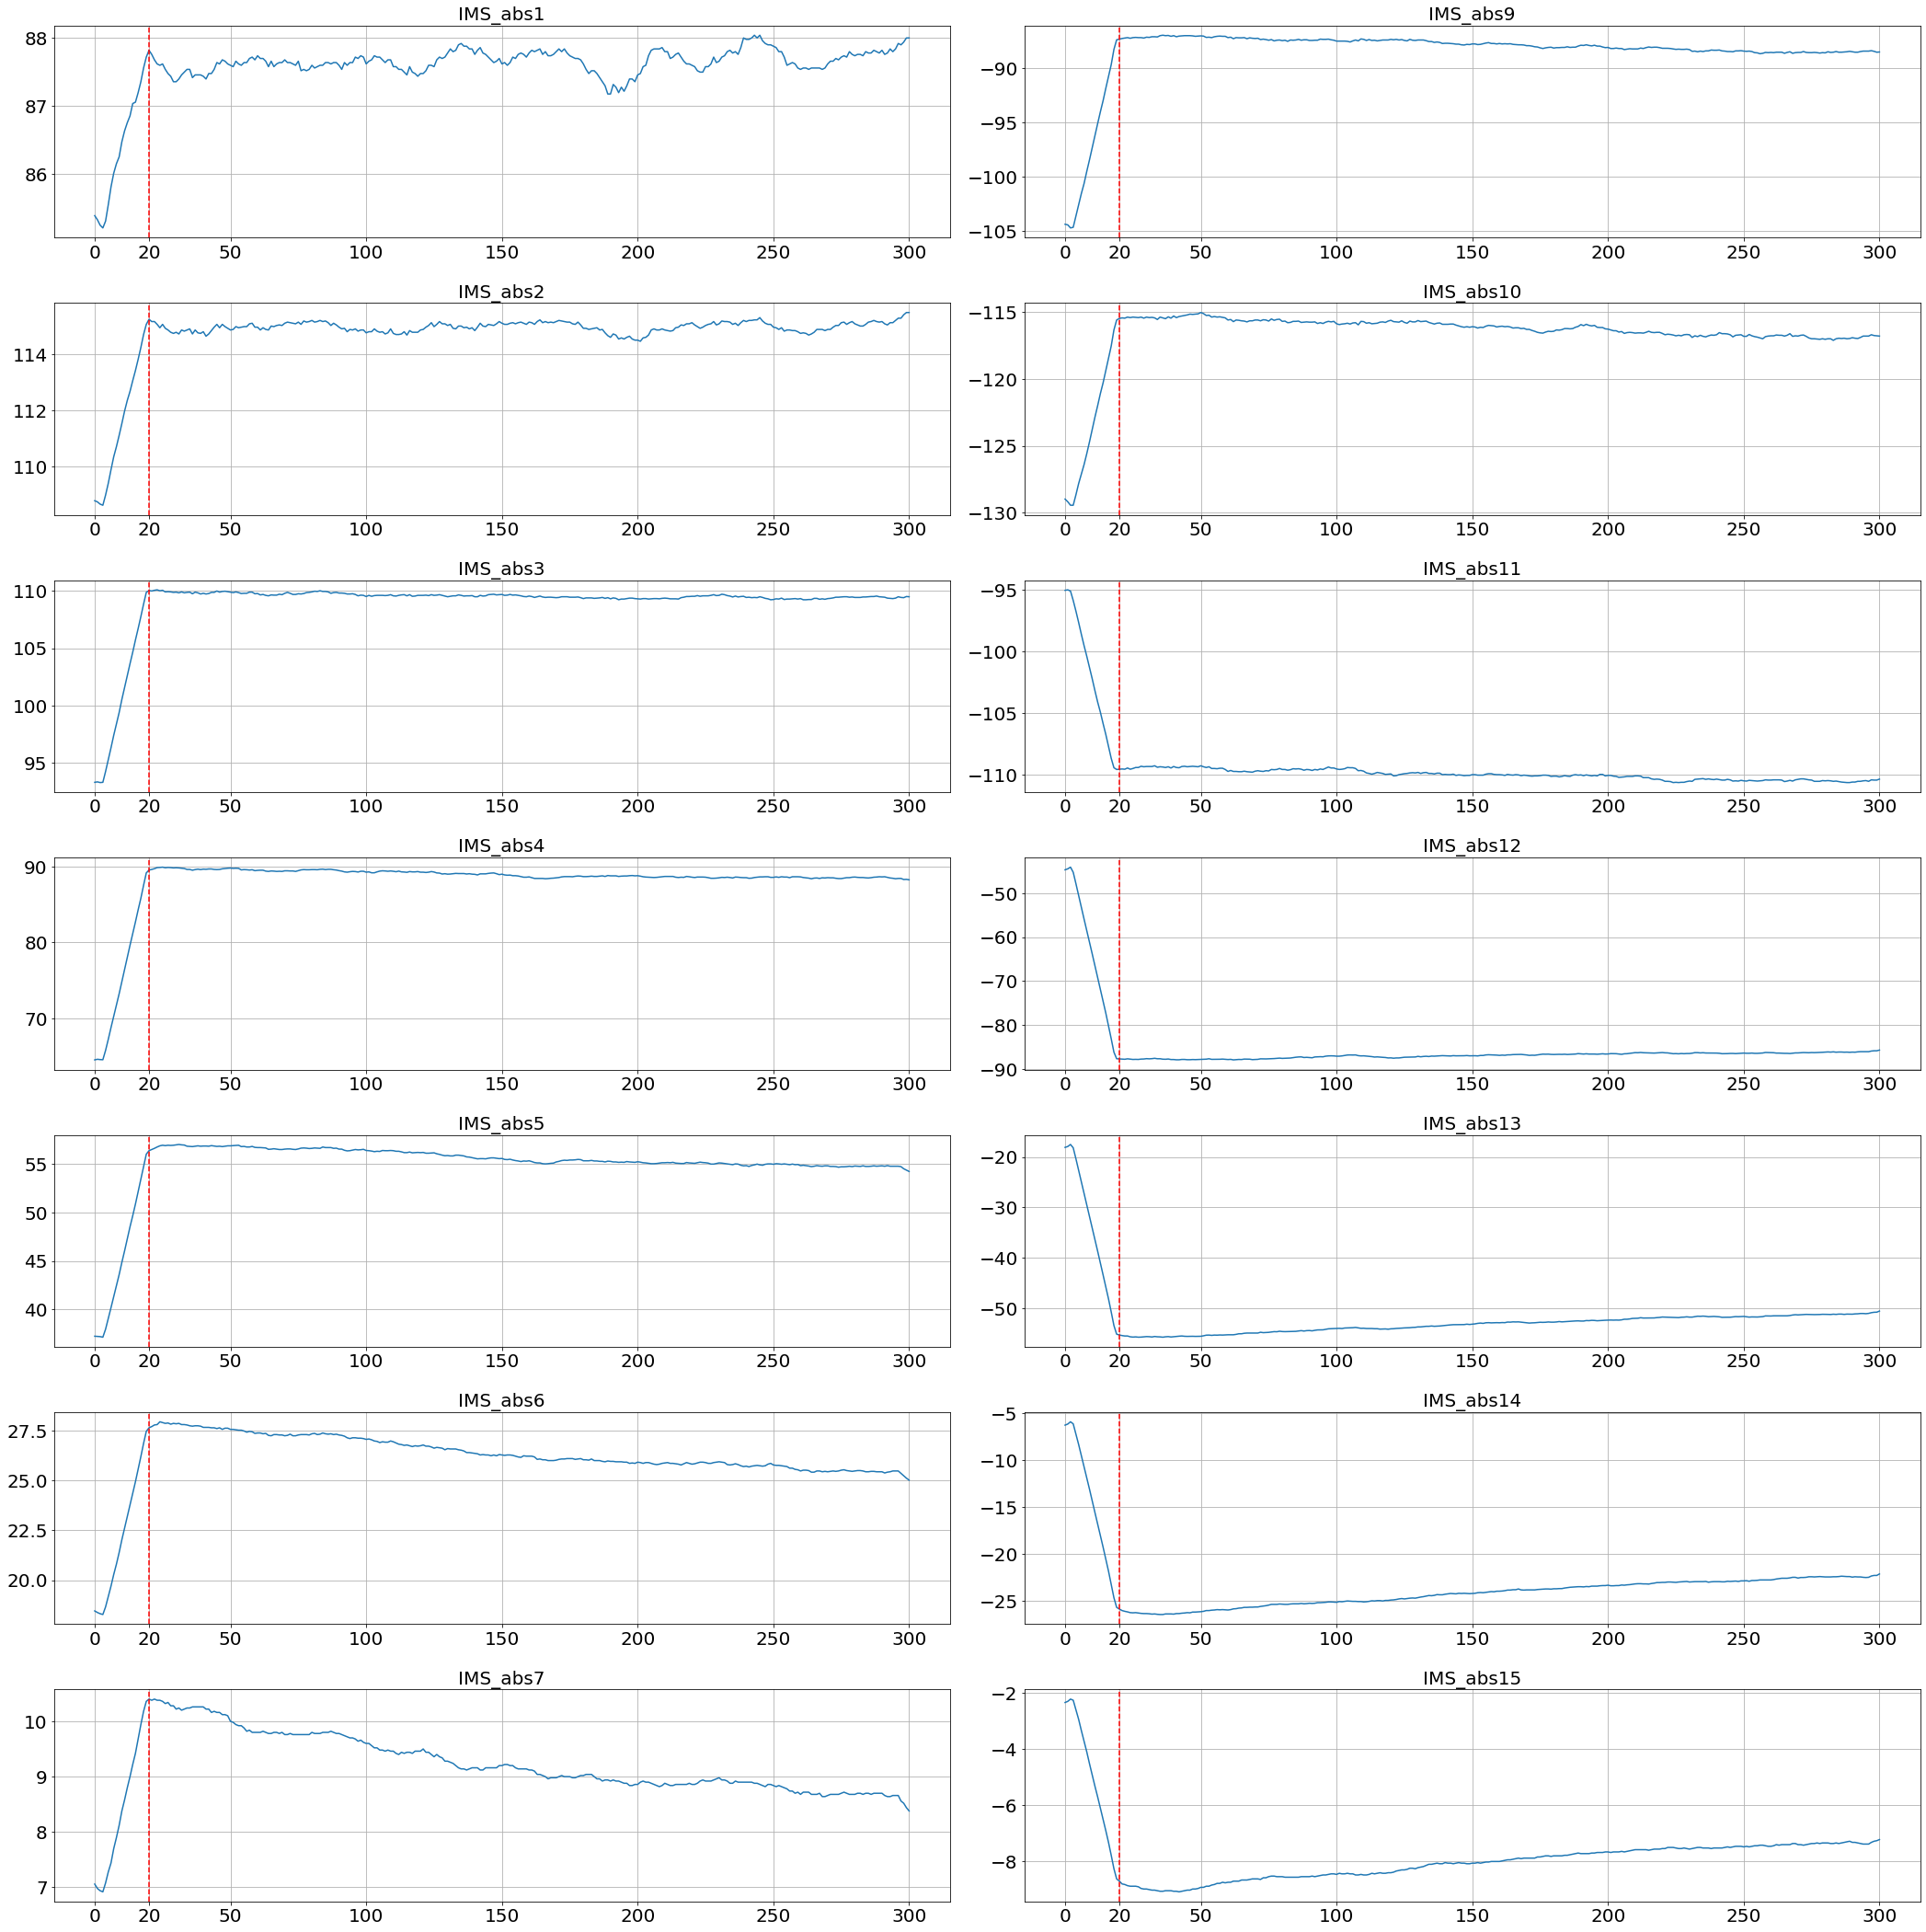

In [29]:
data = pd.read_csv(folder + file)
print(data.shape)
#draw_plots(data, point, fig_size=(10,30), caption=file)
fig, ax = plt.subplots(7,2)
plt.rcParams['figure.figsize'] = [30, 30]
fig.tight_layout(pad=5)
l = 0
r = 0
for key in data:
    if r > 6:
        r = 0
        l = 1
    ax[r,l].plot(data[key])
    ax[r,l].grid(True)
    ax[r,l].set_title(key, fontsize=20)
    ax[r,l].axvline(point, color='red', ls='dashed')
    r += 1
plt.draw()
for i in range(7):
    locs = list(np.arange(-50,350,50))
    locs += [point]
    labels = [str(w) for w in locs]
    for j in range(2):
        ax[i,j].set_xticks(locs[1:])
        ax[i,j].set_xticklabels(labels[1:], fontsize=20)
        ax[i,j].tick_params(axis='y', labelsize=20)
    #ax[i,0].set_xticks(locs[1:])
    #ax[i,0].set_xticklabels(labels[1:], fontsize=10)
    #ax[i,1].set_xticks(locs[1:])
    #ax[i,1].set_xticklabels(labels[1:], fontsize=10)

## Matrix form CUSUM

0.000308990478515625


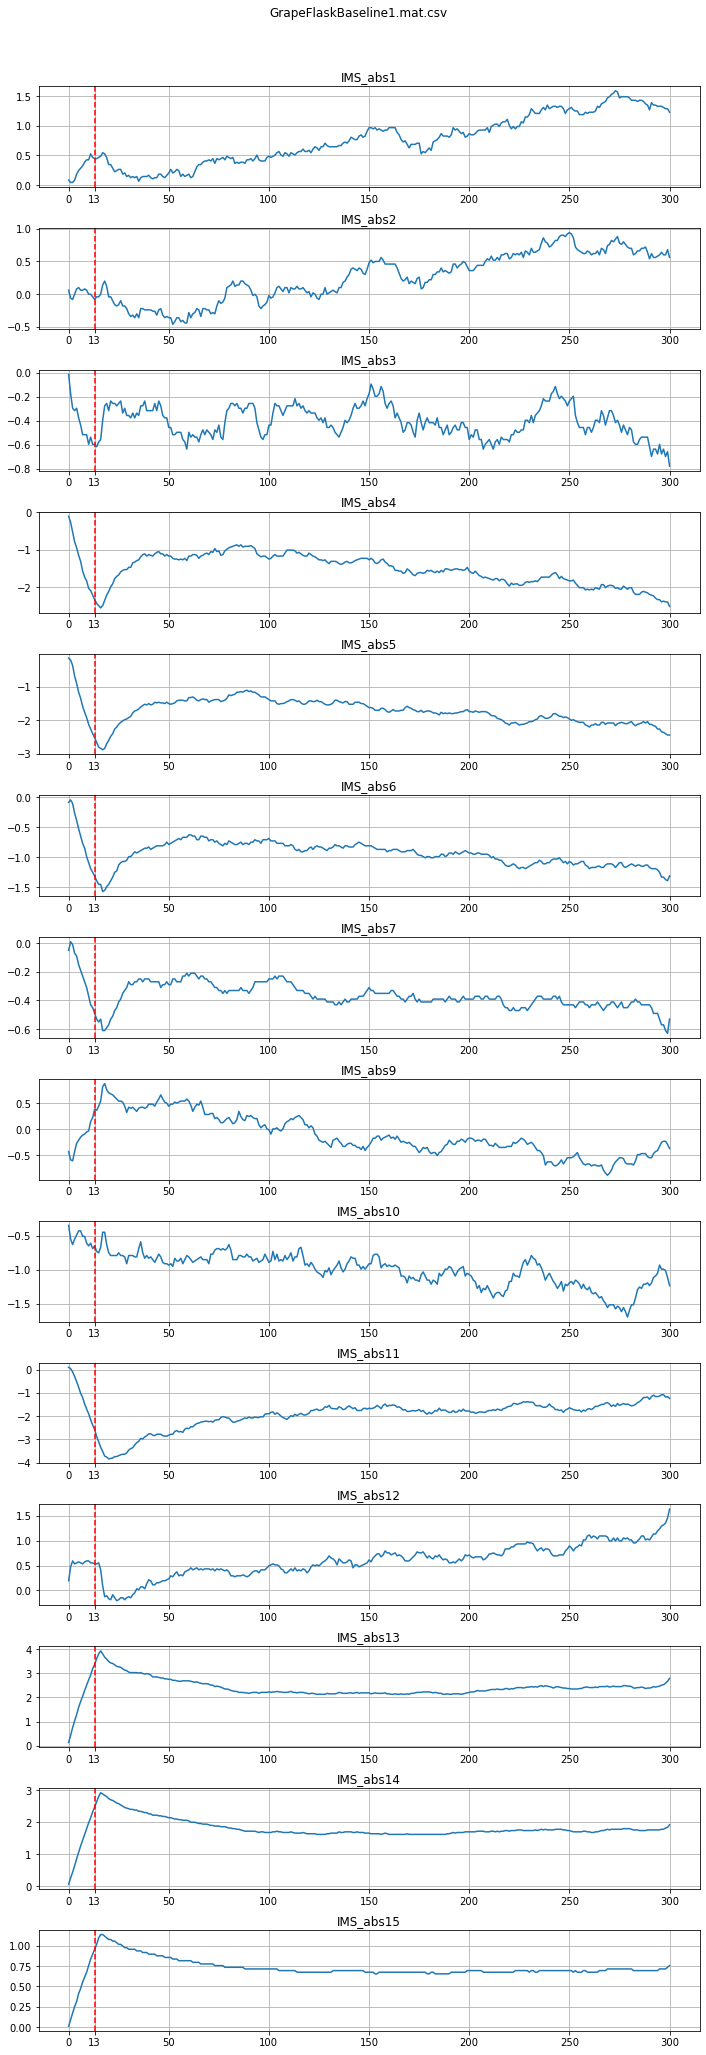

In [6]:
from LCUSUM import LCUSUM_dynamic_window as lc
mc = lc(ts[:,:10],10) # 5,5
tm = time.time()
for i in range(ts.shape[1]):
    detected = mc.LLR(ts[:,i:i+5])
    if detected:
        break
point = mc.get_results()
print(time.time() - tm)
draw_plots(data, point, fig_size=(10,30), caption=file)